In [6]:
import os
import matplotlib.pylab as pylab
import scipy.io
import scipy.misc
import numpy as np
from keras import backend as K
from keras.models import load_model

# 주의: yad2k 모듈 함수 사용됨
# 현재 경로에 yad2k 폴더가 있어야 함, 그렇지 않으면 에러 발생
from yad2k.models.keras_yolo import yolo_head, yolo_eval
import colorsys, imghdr, random
from PIL import Image, ImageDraw, ImageFont

In [7]:
def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
    return class_names

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) \
                  for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), \
                                 int(x[2] * 255)), colors))
    random.seed(10101) # 일관된 색상 유지위한 고정 시드
    random.shuffle(colors) # 인접 클래스 연관 않기 위해 색상 섞음
    random.seed(None) # 시드 리셋
    return colors

def scale_boxes(boxes, image_shape):
    """ 영상에 그릴 예측 사각형 크기 변경 """
    height, width = image_shape[:2]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

In [8]:
def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    size = tuple(reversed(model_image_size))
    resized_image = image.resize(size, Image.BICUBIC)
    
    image_data = np.array(resized_image, dtype='float32') / 255
    image_data = np.expand_dims(image_data, 0) # 배치 차원 추가
    return image, image_data

def draw_boxes(image, out_scores, out_boxes, out_classes, \
               class_names, colors):
    size = np.round(3e-2 * image.size[1]).astype('int32')
    font = ImageFont.truetype(font='arial.ttf', size=size)
    thickness = (image.size[0] + image.size[1]) // 300
    
    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        label = '{} {:.2f}'.format(predicted_class, out_scores[i])
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        
        y1, x1, y2, x2 = map(int, out_boxes[i])
        y1, x1 = max(0, np.round(y1)), max(0, np.round(x1))
        y2 = min(image.size[1], np.round(y2))
        x2 = min(image.size[0], np.round(x2))
        print(label, (x1, y1), (x2, y2))
        
        y = y1 - label_size[1]
        text_origin = np.array([x1, y if y > 0 else y1+1]) # 글자 좌표        
        for i in range(thickness):
            draw.rectangle([x1+i, y1+i, x2-i, y2-i], outline=colors[c])
            
        box = [tuple(text_origin), tuple(text_origin+label_size)] # 검출 사각형
        draw.rectangle(box, fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

In [9]:
# 네트워크에 제공(fed)되는 영상 폴더에 저장된 영상의 이름
input_image_name = "giraffe_zebra.jpg"
input_image = Image.open("../images/" + input_image_name)
width, height = input_image.size
width = np.array(width, dtype=float)
height = np.array(height, dtype=float)

image_shape = (height, width)
# yolo 폴더에 복사된 앵커 박스 및 클래스 파일로드
class_names = read_classes("yolo/coco_classes.txt")
anchors = read_anchors("yolo/yolo_anchors.txt")

yolo_model = load_model("yolo/yolo.h5") # 사전 학습된 모델 로드
yolo_model.summary() # 모델 요약 출력

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

Found 5 boxes for giraffe_zebra.jpg
zebra 0.83 (15, 325) (126, 477)
giraffe 0.89 (56, 175) (272, 457)
zebra 0.91 (370, 326) (582, 471)
giraffe 0.94 (388, 118) (553, 415)
giraffe 0.95 (205, 111) (388, 463)


C:\Users\bae22\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


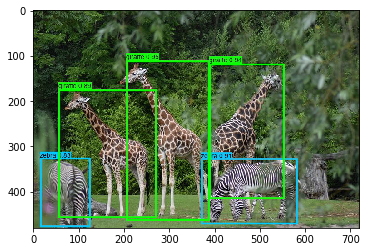

In [10]:
# 최종 계층 특징을 경계 사각형 매개 변수로 변환
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
# yolo_eval() 함수는 최선의 사각형 선택 - 필터링과 비최대 억제 기술을 사용
# 세부 작동 방법은 yad2k/models 폴더의 keras_yolo.py 파일 참조
boxes, scores, classes = yolo_eval(yolo_outputs, image_shape)

sess = K.get_session() # 세션 초기화
# 컨볼루션 네트워크에 입력하기 전에 입력영상 전처리
image, image_data = preprocess_image("../images/" + input_image_name, \
                                     model_image_size = (608, 608))
#세션 실행
feed_dict = {yolo_model.input:image_data,K.learning_phase(): 0}
out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],\
                                              feed_dict=feed_dict)
# 결과 출력
print('Found {} boxes for {}'.format(len(out_boxes), input_image_name))
#Found 5 boxes for giraffe_zebra.jpg
#zebra 0.83 (16, 325) (126, 477)
#giraffe 0.89 (56, 175) (272, 457)
#zebra 0.91 (370, 326) (583, 472)
#giraffe 0.94 (388, 119) (554, 415)
#giraffe 0.95 (205, 111) (388, 463)

# 경계 사각형 색상 생성 및 그리기
colors = generate_colors(class_names)
draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)

#예측된 경계 사각형 그려진 영상 저장
image.save(os.path.join("output", input_image_name), quality=90)
output_image = scipy.misc.imread(os.path.join("output", input_image_name))
pylab.imshow(output_image)
pylab.show()